# Quantum Circuit Builder

In this notebook, I try to make a quantum circuit builder

In [63]:
# Importing libraries
import numpy as np
import qutip as q
import matplotlib.pyplot as plt
import random

### Numpy

The first approach is to use numpy for everything (that is no QuTip)

In [64]:
# Defining qbit states 0 and 1
bra0 = np.array([[1, 0]])                   # Bra vector for state |0>
ket0 = bra0.T                               # Ket vector for state |0>
bra1 = np.array([[0, 1]])                   # Bra vector for state |1>
ket1 = bra1.T                               # Ket vector for state |1>
# Defining identity operator and Pauli operators
I = np.eye(2)                               # Identity operator
sigx = np.array([[0, 1], [1, 0]])           # Pauli-X operator
sigy = np.array([[0, -1j], [1j, 0]])        # Pauli-Y operator
sigz = np.array([[1, 0], [0, -1]])          # Pauli-Z operator
# Defining gate operators H, S, T, CNOT, and SWAP
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2) # Hadamard gate
S = np.array([[1, 0], [0, 1j]])         # S gate (phase gate)
T = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]]) # T gate (π/8 gate)
# Defining dyadic rational phase gate
def R(k):
    return np.array([[1, 0], [0, np.exp(2j*np.pi/2**k)]])

After defining all the relevant gates, I define a function that applies single qubit gates on each qubit and then takes the kronecker product in the end

In [65]:
def QuantumCircuit(states, gates, targets):
    
    """
    Applies a sequence of gates to specified qubits in a quantum state.
    
    Parameters:
    states (numpy.ndarray): The initial quantum states.
    gates (list): A list of gate operators to apply.
    targets (list): A list of target qubit indices for each gate.
    
    Returns:
    numpy.ndarray: The final quantum state after applying all gates.
    """

    # Determine the number of qubits
    N = int(np.size(states)/2)

    # Check if the number of gates matches the number of targets
    if len(gates) != len(targets):
        raise ValueError("The number of gates must match the number of targets.")
    # Check if any of the targets are out of range
    for target in targets:
        if target < 0 or target >= N:
            raise ValueError(f"Target {target} is out of range for {N} qubits.")
    
    for i in range(len(gates)):
        temp = gates[i] @ states[targets[i]]
        states[targets[i]] = temp / np.linalg.norm(temp)  # Normalize the state

    return states

In [66]:
# Define states, gates, and targets
states = [ket0, ket0]  # Initial state |00>
gates = [H] # Apply Hadamard gates to both qubits
targets = [0]  # Apply to both qubits

In [67]:
states

[array([[1],
        [0]]),
 array([[1],
        [0]])]

In [68]:
QuantumCircuit(states, gates, targets)

[array([[0.70710678],
        [0.70710678]]),
 array([[1],
        [0]])]

Okay, this is all fine and well, but we need 2-qubit gates as well. To implement these, one has to use kroneker products for all the unitaries and states.

Now the function bellow is used to generate the unitary from a single-qubit gate.

In [69]:
def generateUnitary(gate, target, N):
    """
    Applies given single-qubit gate to specified qubit positions in an N-qubit system.
    Parameters:
        gate (np.ndarray): Single-qubit gate matrix.
        target (int): Qubit index (1-based).
        N (int): Total number of qubits.
    Returns:
        np.ndarray: Full operator as a Kronecker product.
    """
    
    # Start with identity on all qubits
    operators = [I for _ in range(N)]
    
    # If target is 0, apply the gate to all qubits
    if target == 0:
        # Apply to all qubits
        for i in range(N):
            operators[i] = gate
    else:
        # Apply to specific (1-indexed) qubit
        if not (1 <= target <= N):
            raise ValueError(f"Target index {target} out of bounds for {N} qubits.")
        operators[target - 1] = gate

    # Compute Kronecker product (qubit 1 = leftmost)
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

In [70]:
generateUnitary(gate=H, target=0, N=3)

array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,
         0.35355339,  0.35355339,  0.35355339],
       [ 0.35355339, -0.35355339,  0.35355339, -0.35355339,  0.35355339,
        -0.35355339,  0.35355339, -0.35355339],
       [ 0.35355339,  0.35355339, -0.35355339, -0.35355339,  0.35355339,
         0.35355339, -0.35355339, -0.35355339],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339,
        -0.35355339, -0.35355339,  0.35355339],
       [ 0.35355339,  0.35355339,  0.35355339,  0.35355339, -0.35355339,
        -0.35355339, -0.35355339, -0.35355339],
       [ 0.35355339, -0.35355339,  0.35355339, -0.35355339, -0.35355339,
         0.35355339, -0.35355339,  0.35355339],
       [ 0.35355339,  0.35355339, -0.35355339, -0.35355339, -0.35355339,
        -0.35355339,  0.35355339,  0.35355339],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339, -0.35355339,
         0.35355339,  0.35355339, -0.35355339]])

In [71]:
# Define states, gates, and targets
states = [ket0, ket0] # Initial state |00>
gates = [H]
targets = [0]
N = len(states)

In [72]:
#UT = generateUnitary(gates, targets, N)
#print(UT)
#state = np.kron(states[0], states[1])
#result = UT @ state
#result /= np.linalg.norm(result)
#print(result)

This works well. Now it would be nice to expand onto 2-qubit gates.

In [73]:
# Define a function to compute the Kronecker product of multiple operators
def kron_all(op_list):
    result = op_list[0]
    for op in op_list[1:]:
        result = np.kron(result, op)
    return result

In [74]:
def SingleQubitGate(gate, targets, N):
    """
    Applies a single-qubit gate to specified qubit positions in an N-qubit system.
    Parameters:
        gate (np.ndarray): Single-qubit gate matrix.
        targets (list): Qubit indicies (0-based).
        N (int): Total number of qubits.
    Returns:
        np.ndarray: Full operator as a Kronecker product.
    """
    # Start with identity on all qubits
    operators = [I for _ in range(N)]

    for target in targets:
        # Validate target index
        if not (0 <= target < N):
            raise ValueError(f"Target index {target} out of bounds for {N} qubits.")
        
        # Apply the gate to the specified qubit
        operators[target] = gate
    
    # Compute Kronecker product
    return kron_all(operators)

In [75]:
def ControlQubitGate(gate, control, target, N):
    """
    Constructs a controlled single-qubit gate for a given control and target qubit in an N-qubit system.
    Parameters:
        gate (np.ndarray): Single-qubit gate matrix.
        control (int): Control qubit index (0-based).
        target (int): Target qubit index (0-based).
        N (int): Total number of qubits.
    Returns:
        np.ndarray: Full operator as a Kronecker product.
    """
    if not (0 <= control < N) or not (0 <= target < N):
        raise ValueError(f"Control {control} and target {target} must be between 0 and {N-1}.")
    if control == target:
        raise ValueError("Control and target cannot be the same.")
    
    # Start with identities
    ops1 = [I for _ in range(N)]
    ops2 = [I for _ in range(N)]

    # Conditional operators
    ops1[control] = ket0 @ bra0  # projector |0⟩⟨0|
    ops2[control] = ket1 @ bra1  # projector |1⟩⟨1|
    ops2[target] = gate          # apply gate to target if control is |1⟩

    return kron_all(ops1) + kron_all(ops2)

In [76]:
SingleQubitGate(gate=H, targets=[0, 1], N=2)

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5]])

In [77]:
ControlQubitGate(gate=sigx, control=1, target=0, N=2)

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

Now I try to make classes that can be used for easier computation

In [78]:
# Defining the QuantumState class
class QuantumState:
    def __init__(self, state_input):
        """
        Parameters:
            state_input (str or np.ndarray): Either a bitstring like "010" or a
            complex vector (1D numpy array).
        """
        # Check the type of input and initialize the state
        if isinstance(state_input, str):
            self.bitstring = state_input.strip()
            self.N = len(self.bitstring)
            self.dim = 2 ** self.N
            self.state = np.zeros((self.dim,), dtype=complex)
            index = int(self.bitstring, 2)
            self.state[index] = 1.0 + 0j
        elif isinstance(state_input, np.ndarray):
            if state_input.ndim != 1:
                raise ValueError("State vector must be 1D.")
            dim = state_input.shape[0]
            N = int(np.log2(dim))
            if 2 ** N != dim:
                raise ValueError("Length of state vector must be a power of 2.")
            self.state = np.array(state_input, dtype=complex)  # defensive copy
            self.N = N
            self.dim = dim
        else:
            raise TypeError("Input must be a bitstring (str) or a 1D NumPy array.")
        # Normalize the state upond
        self._normalize()

    def _normalize(self):
        norm = np.linalg.norm(self.state)
        if norm == 0:
            raise ValueError("Quantum state has zero norm.")
        self.state = self.state / norm

    def apply_circuit(self, qc):
        if qc.N != self.N:
            raise ValueError(f"QuantumCircuit has {qc.N} qubits but state has {self.N}.")
        self.state = qc.apply_to_state(self.state)
        self._normalize()

    def measure(self, qubits):
        """
        Measures the given qubit(s) and collapses the state accordingly.
        Parameters:
            qubits (list): Indices of qubits to measure (0 = leftmost).
        Returns:
            str: Bitstring result of measurement (qubit 0 is leftmost).
        """
        if isinstance(qubits, int):
            qubits = [qubits]

        for q in qubits:
            if not (0 <= q < self.N):
                raise ValueError(f"Qubit index {q} is out of bounds.")

        probs = np.abs(self.state) ** 2
        basis_states = [format(i, f"0{self.N}b") for i in range(self.dim)]

        # Compute probabilities for each outcome of the measured qubits
        outcome_probs = {}
        for i, b in enumerate(basis_states):
            key = ''.join(b[q] for q in qubits)  # Qubit 0 = leftmost
            outcome_probs.setdefault(key, 0)
            outcome_probs[key] += probs[i]

        # Filter only outcomes with nonzero probability
        nonzero_outcomes = {k: v for k, v in outcome_probs.items() if v > 1e-12}

        if not nonzero_outcomes:
            raise RuntimeError("State has no valid measurement outcomes. This should not happen.")

        # If only one possible outcome → deterministic, no collapse
        if len(nonzero_outcomes) == 1:
            return next(iter(nonzero_outcomes))  # return the single outcome

        # Otherwise, sample one outcome probabilistically
        outcomes = list(nonzero_outcomes.keys())
        weights = [nonzero_outcomes[k] for k in outcomes]
        chosen = random.choices(outcomes, weights=weights)[0]

        # Collapse the state to match measured outcome
        new_state = np.zeros_like(self.state)
        for i, b in enumerate(basis_states):
            key = ''.join(b[q] for q in qubits)
            if key == chosen:
                new_state[i] = self.state[i]

        self.state = new_state
        self._normalize()

        return chosen

    def __str__(self):
        terms = []
        for i, amp in enumerate(self.state):
            if np.abs(amp) > 1e-10:
                bitstring = format(i, f'0{self.N}b')
                coeff = amp
                if np.isclose(coeff.imag, 0):
                    coeff_str = f"{coeff.real:.3f}"
                elif np.isclose(coeff.real, 0):
                    coeff_str = f"{coeff.imag:.3f}j"
                else:
                    coeff_str = f"({coeff.real:.3f}+{coeff.imag:.3f}j)"
                terms.append(f"{coeff_str}|{bitstring}>")
        return " + ".join(terms)

    def as_vector(self):
        return self.state.copy()

In [79]:
class QuantumCircuit:
    def __init__(self, num_qubits):
        self.N = num_qubits
        self.unitary = np.eye(2 ** self.N)
        self.operations = []  # To store gates for visualization

    def apply_single(self, gate, targets, name="U"):
        full_gate = SingleQubitGate(gate, targets, self.N)
        self.unitary = full_gate @ self.unitary
        self.operations.append(("single", name, targets))

    def apply_controlled(self, gate, control, target, name="CU"):
        full_gate = ControlQubitGate(gate, control, target, self.N)
        self.unitary = full_gate @ self.unitary
        self.operations.append(("control", name, control, target))

    def get_unitary(self):
        return self.unitary

    def apply_to_state(self, state):
        if len(state) != 2 ** self.N:
            raise ValueError(f"State vector must have length {2 ** self.N}.")
        return self.unitary @ state

    def draw(self):
        """Prints a text-based circuit diagram."""
        print("Circuit diagram:")
        layers = []
        for op in self.operations:
            layer = ["───" for _ in range(self.N)]  # one "time step"
            if op[0] == "single":
                name = op[1]
                for target in op[2]:
                    layer[target] = f"-{name}-"
            elif op[0] == "control":
                name = op[1]
                c, t = op[2], op[3]
                min_q, max_q = min(c, t), max(c, t)
                for i in range(min_q + 1, max_q):
                    layer[i] = " │ "
                layer[c] = " ● "
                layer[t] = f"-{name[-1]}-"
            layers.append(layer)

        # Transpose layers to qubit lines
        for q in range(self.N):
            line = f"q{q} | "
            for layer in layers:
                line += layer[q]
            print(line)
        #print("Total number of gates:", len(self.operations))

In [88]:
# Initialize a 3-qubit circuit
qc = QuantumCircuit(3)

# Apply Hadamard to both qubits
qc.apply_single(gate=H, targets=[0, 1], name='H')

# Apply S to qubit 1
qc.apply_single(gate=S, targets=[1], name='S')

# Apply CNOT with control=0, target=1
qc.apply_controlled(sigx, control=0, target=1, name='CX')

# Apply Hadamard to both qubits
qc.apply_single(gate=H, targets=[0, 1], name='H')

# Draw the circuit
qc.draw()

# Create quantum state |000⟩
qs = QuantumState("000")
print("Initial state:")
print(qs)
# Apply circuit
qs.apply_circuit(qc)
print("After applying circuit:")
print(qs)
# Measure the first qubit
result = qs.measure([0, 1, 2])
print("Measurement result for qubits 1 and 2:", result)
print(qs)

Circuit diagram:
q0 | -H-─── ● -H-
q1 | -H--S--X--H-
q2 | ────────────
Initial state:
1.000|000>
After applying circuit:
(0.500+0.500j)|000> + (0.500+-0.500j)|110>
Measurement result for qubits 1 and 2: 000
(0.707+0.707j)|000>


In [81]:
# Initialize a 3-qubit circuit
qc = QuantumCircuit(3)

# Apply Hadamard to qubit 0
qc.apply_single(gate=H, targets=[0], name='H')
# Apply CR2 gate to qubit 0
qc.apply_controlled(gate=R(2), control=1, target=0, name='R2')
# Apply CR3 gate to qubit 0
qc.apply_controlled(gate=R(3), control=2, target=0, name='R3')
# Apply Hadamard to qubit 1
qc.apply_single(gate=H, targets=[1], name='H')
# Apply CR2 gate to qubit 1
qc.apply_controlled(gate=R(2), control=2, target=1, name='R2')
# Apply Hadamard to qubit 2
qc.apply_single(gate=H, targets=[2], name='H')

# Draw the circuit
print("Circuit diagram:")
qc.draw()

# Create quantum state |000⟩
qs = QuantumState("000")
print("Initial state:")
print(qs)
# Apply circuit
qs.apply_circuit(qc)
print("After applying circuit:")
print(qs)
# Measure the first qubit
result = qs.measure([0, 1])
print("Measurement result for qubits 0:", result)
print(qs)

Circuit diagram:
Circuit diagram:
q0 | -H--2--3-─────────
q1 | ─── ●  │ -H--2-───
q2 | ────── ● ─── ● -H-
Initial state:
1.000|000>
After applying circuit:
0.354|000> + 0.354|001> + 0.354|010> + 0.354|011> + 0.354|100> + 0.354|101> + 0.354|110> + 0.354|111>
Measurement result for qubits 0: 11
0.707|110> + 0.707|111>


In [84]:
# Create a quantum state |000⟩ + |111⟩
vec = np.zeros(8, dtype=complex)
vec[0] = 1
vec[7] = 1
qs = QuantumState(vec)
print("Initial state:")
print(qs)
# Apply circuit
qs.apply_circuit(qc)
print("After applying circuit:")
print(qs)

Initial state:
0.707|000> + 0.707|111>
After applying circuit:
0.500|000> + (0.250+-0.250j)|010> + (0.250+0.250j)|011> + (0.427+-0.177j)|100> + (0.073+0.177j)|101> + (0.073+-0.177j)|110> + (0.427+0.177j)|111>


### QuTip

In [1]:
import qutip
import numpy as np
from qutip import Qobj
from qutip_qip.operations import rx
from qutip_qip.circuit import QubitCircuit

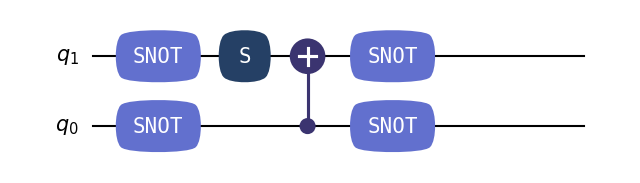

In [21]:
qc = QubitCircuit(2, reverse_states=False)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.add_gate("S", targets=1)
qc.add_gate("CNOT", controls=0, targets=1)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.draw()